## Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Create a Jupyter Notebook file called `climate_analysis.ipynb` and use it to complete your climate analysis and data exporation.

* Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

* Use SQLAlchemy `create_engine` to connect to your sqlite database.

* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import sqlalchemy
from sqlalchemy import create_engine, MetaData, inspect, func, desc #connect to database
from sqlalchemy.ext.automap import automap_base #classes into tables
from sqlalchemy import Column, Integer, String, Float, DateTime #allow us to declare column typs
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
import pymysql

import matplotlib
# matplotlib.use('nbagg')
# from matplotlib import style
# style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

pymysql.install_as_MySQLdb() # starts creating connection from Python to SQL database

In [2]:
# Create our database engine
engine = create_engine('sqlite:///hawaii.sqlite')
conn = engine.connect()

# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# Assign the dow class to a variable called
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create a session
session = Session(engine)

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Plot the results using the DataFrame `plot` method.

* Use Pandas to print the summary statistics for the precipitation data.

In [3]:
# Earliest Date in data
firstDate = session.query(Measurement.date).order_by(Measurement.date).first()
firstDateTime = datetime.strptime(firstDate[0],'%Y-%m-%d')

# Latest Date in data
lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastDateTime = datetime.strptime(lastDate[0],'%Y-%m-%d')

# Calculate the date 1 year ago
oneYearAgoDate = datetime.date(lastDateTime) - dt.timedelta(days=365)

In [4]:
# Select precipitation data
selOneYearData = [
                    Measurement.date,
                    func.avg(Measurement.prcp)
                 ]

# Query data from database and filter/group
oneYearData = session.query(*selOneYearData).\
    filter(Measurement.date < lastDateTime, Measurement.date >= oneYearAgoDate).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

# Create DataFrame
yearDataDF = pd.DataFrame(oneYearData, columns=['date', 'precipitation'])
yearDataDF.set_index('date', inplace=True)
yearDataDF.head()

,precipitation
date,
2016-08-23,0.387143
2016-08-24,1.332857
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.053333


In [5]:
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)  
# plt.plot(yearDataDF)

# # ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))   #to get a tick every 15 minutes
# # ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 

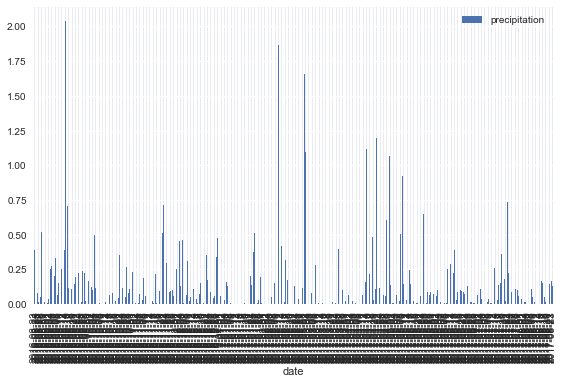

NameError: name 'df' is not defined

In [6]:

import pylab
import matplotlib
import matplotlib.dates

yearDataDF.plot.bar()
plt.tight_layout()
plt.show()


df.plot.bar()
plt.tight_layout()
plt.show()

x = range(len(ptps))
ax.boxplot(ptps, patch_artist=True)
ax.set_title('IBM PTPs')
fig.tight_layout()
# fig.show()

### Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order

  * Which station has the highest number of observations?

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

In [8]:
# Figure out most active stations
selStations = [Measurement.station,
               func.count(Measurement.date)
              ]

# Query data from database and filter/group
stationData = session.query(*selStations).\
    group_by(Measurement.station).\
    order_by(Measurement.date).all()
    
# Create DataFrame
stationDataDF = pd.DataFrame(stationData, columns=['station', 'observations'])
stationDataDF = stationDataDF.sort_values('observations', ascending=False)
stationDataDF.set_index('station', inplace=True)
stationDataDF.head()

,observations
station,
USC00519281,5544
USC00519397,5448
USC00513117,5418
USC00519523,5338
USC00516128,5224


In [9]:
# Get tobs observation data
selStationTobs = [
                  Measurement.date,
                  Measurement.tobs
                 ]

# Query data from and filter for station with highest number of observations for the last 12 months
stationDataTobs = session.query(*selStationTobs).\
    filter(Measurement.station == stationDataDF.index.values[0],
           Measurement.date < lastDateTime,
           Measurement.date >= oneYearAgoDate).\
    order_by(Measurement.tobs).all()

# Create DataFrame
stationTobsDataDF = pd.DataFrame(stationDataTobs, columns=['date', 'tobs'])
stationTobsDataDF = stationTobsDataDF.sort_values('date', ascending=True)
stationTobsDataDF.set_index('date', inplace=True)
stationTobsDataDF.head()

,tobs
date,
2016-08-23,77
2016-08-23,77
2016-08-24,77
2016-08-24,77
2016-08-25,80


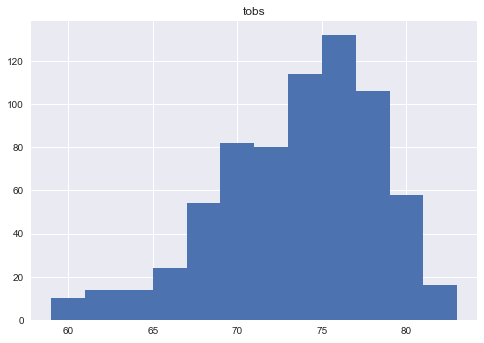

In [10]:
stationTobsDataDF.hist(bins=12)
plt.show()

### Temperature Analysis

* Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plot the min, avg, and max temperature from your previous query as a bar chart.
  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [11]:
# Set start and end dates for trip
start = '2018-5-10'
end = '2018-5-20'

# Define calc_temps function
def calc_temps(startDate,endDate):
    
    # Convert dates to datetime
    startDateDT = datetime.strptime(startDate,'%Y-%m-%d')
    endDateDT = datetime.strptime(endDate,'%Y-%m-%d')
    
    # Find start and end dates from a year ago
    startYA = datetime.date(startDateDT) - dt.timedelta(days=365)
    endYA = datetime.date(endDateDT) - dt.timedelta(days=365)
    
    # Data to select
    sel = [
            Measurement.date,
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs)-func.min(Measurement.tobs)
          ]
    
    # Filter and group data
    selData = session.query(*sel).\
        filter(Measurement.date >= startYA, Measurement.date <= endYA).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()
    
    df = pd.DataFrame(selData, columns=['date', 'average', 'error'])
    df.set_index('date', inplace=True)
    
    return df

# Run calc_temps function
tempDF = calc_temps(start,end)

tempDF

,average,error
date,,
2017-05-10,75.166667,6
2017-05-11,75.600000,8
2017-05-12,75.500000,9
2017-05-13,75.400000,8
2017-05-14,75.400000,8
2017-05-15,75.500000,6
2017-05-16,75.166667,7
2017-05-17,75.500000,7
2017-05-18,71.666667,9


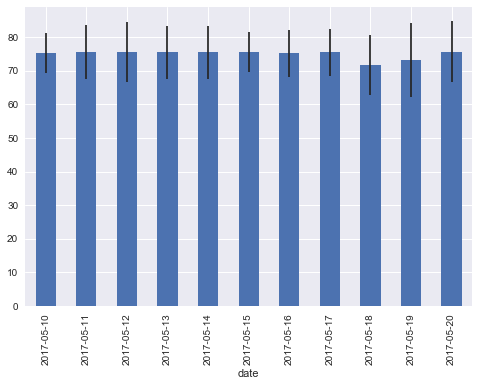

In [28]:
fig, ax = plt.subplots()
plot = tempDF['average'].plot(kind='bar',yerr=tempDF['error'])
plt.show()

# colormap='OrRd_r',edgecolor='black',grid=False,figsize=(8,2),ax=ax,position=0.45,error_kw=dict(ecolor='black',elinewidth=0.5),width=0.8

### Optional Recommended Analysis

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

  * Calcualte the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

  * Create a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

  * Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

  * Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

  * Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [26]:
s = datetime.strptime(start,'%Y-%m-%d')

try:
    e = datetime.strptime(end,'%Y-%m-%d')
    endDate = True
except NameError:
    pass

# Select data
sel = [
        Measurement.date,
        func.avg(Measurement.tobs),
        func.min(Measurement.tobs),
        func.max(Measurement.tobs)
      ]

if endDate == True:
    results = session.query(*sel).\
        filter(Measurement.date >= s, Measurement.date <= e).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()
else:
    results = session.query(*sel).\
        filter(Measurement.date >= s).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Create a dictionary from the row data and append to a list of allDates
dictList = []

for result in results:
        dateDict = {}
        dateDict['date'] = result[0]
        dateDict['tAvg'] = result[1]
        dateDict['tMin'] = result[2]
        dateDict['tMax'] = result[3]
        dictList.append(dateDict)

In [27]:
dictList

[{'date': '2015-05-24', 'tAvg': 71.33333333333333, 'tMax': 73, 'tMin': 69},
 {'date': '2015-05-25', 'tAvg': 71.66666666666667, 'tMax': 74, 'tMin': 68},
 {'date': '2015-05-26', 'tAvg': 70.0, 'tMax': 75, 'tMin': 65},
 {'date': '2015-05-27', 'tAvg': 70.14285714285714, 'tMax': 76, 'tMin': 65},
 {'date': '2015-05-28', 'tAvg': 71.75, 'tMax': 77, 'tMin': 67},
 {'date': '2015-05-29', 'tAvg': 71.0, 'tMax': 78, 'tMin': 64},
 {'date': '2015-05-30', 'tAvg': 73.83333333333333, 'tMax': 78, 'tMin': 70},
 {'date': '2015-05-31', 'tAvg': 73.6, 'tMax': 77, 'tMin': 69},
 {'date': '2015-06-01', 'tAvg': 74.66666666666667, 'tMax': 78, 'tMin': 69},
 {'date': '2015-06-02', 'tAvg': 72.6, 'tMax': 78, 'tMin': 67},
 {'date': '2015-06-03', 'tAvg': 73.85714285714286, 'tMax': 79, 'tMin': 68},
 {'date': '2015-06-04', 'tAvg': 72.71428571428571, 'tMax': 77, 'tMin': 68},
 {'date': '2015-06-05', 'tAvg': 73.85714285714286, 'tMax': 79, 'tMin': 68},
 {'date': '2015-06-06', 'tAvg': 77.0, 'tMax': 80, 'tMin': 71},
 {'date': '20